In [1]:
import os
import sys
sys.path.append("/home/dux/")
sys.path.append("/home/dux/surface_sampling/sgmc_surf")

from mcmc import initialize_slab, mcmc_run

from ase.calculators.lammpsrun import LAMMPS

import numpy as np

In [2]:
from time import perf_counter

# initialize some parameters first
# Cu alat from https://www.copper.org/resources/properties/atomic_properties.html
Cu_alat = 3.6147
slab = initialize_slab(Cu_alat, size=(2, 2, 2))

chem_pot = 0 # chem pot 0 to less complicate things
alpha = 0.99 # slowly anneal
temp = 1 # temp in terms of kbT
num_sweeps = 100

# use LAMMPS
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Cu_u3.eam']
}

potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Cu_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=False, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

start = perf_counter()
# call the main function
history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_sweeps=num_sweeps, temp=temp, pot=chem_pot, alpha=alpha, slab=slab, calc=lammps_calc)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

/home/dux/miniconda3/envs/surface_sampling/lib/python3.8/site-packages/catkit/gen/surface.py:334: UserWarning: Your slab has no bulk atoms and may be too thin to identify surface atoms correctly. This may cause surface adsorption site identification to fail.
  warnings.warn(
INFO:Running with num_sweeps = 100, temp = 1, pot = 0, alpha = 0.99
INFO:there are 8 atoms 
INFO:using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7ff65b280af0>
/home/dux/miniconda3/envs/surface_sampling/lib/python3.8/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/miniconda3/envs/surface_sampling/lib/python3.8/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating a

Time taken = 37.292506493628025 seconds


In [3]:
energy_hist

array([-36.55821387, -36.55821387, -36.55821387, -36.55821387,
       -36.55821387, -36.55821387, -36.55821387, -36.55821387,
       -36.55821387, -36.55821387, -32.49255263, -31.53264031,
       -36.06213852, -36.06213852, -36.06213852, -36.06213852,
       -36.06213852, -36.06213852, -36.06213852, -36.06213852,
       -36.06213852, -36.06213852, -36.06213852, -36.06213852,
       -36.06213852, -36.06213852, -32.33007927, -32.4821419 ,
       -37.17912738, -41.07614427, -47.30809647, -44.38191789,
       -47.30809647, -47.30809647, -47.30809647, -47.30809647,
       -47.30809647, -47.30809647, -47.30809647, -47.30809647,
       -47.30809647, -47.30809647, -47.30809647, -47.30809647,
       -47.30809647, -47.30809647, -47.30809647, -47.30809647,
       -47.30809647, -47.30809647, -47.30809647, -47.30809647,
       -47.30809647, -47.30809647, -47.30809647, -47.30809647,
       -47.30809647, -47.30809647, -47.30809647, -47.30809647,
       -47.30809647, -47.30809647, -47.30809647, -47.30

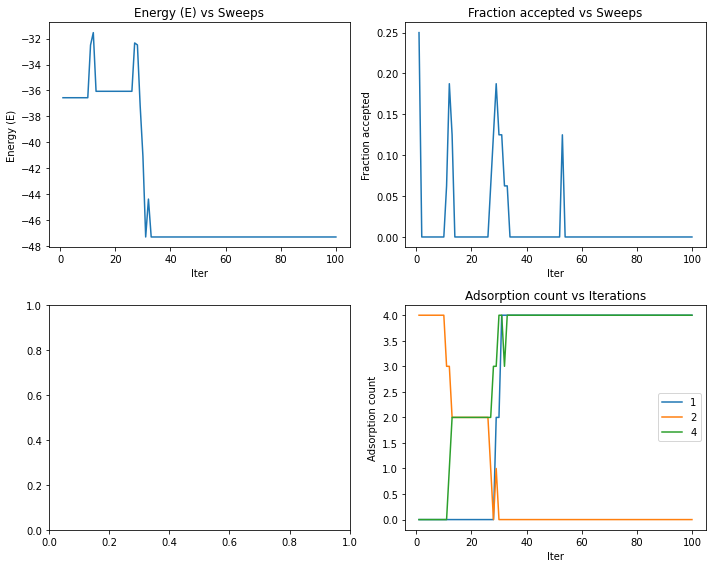

In [4]:
import matplotlib.pyplot as plt
runs = range(1, num_sweeps+1)
# some plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Sweeps")

ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Sweeps")

ax[1, 1].plot(runs, np.array(list(adsorption_count_hist.values())).T)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].legend(adsorption_count_hist.keys())
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()